# U-Net Model for Segmentation


In [1]:
import numpy as np
import tensorflow as tf 
import pandas as pd 
from skimage.util.montage import montage2d
import os
from cv2 import imread, createCLAHE
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [26]:
#Version Check
import keras
print("Using tensorflow: "+tf.__version__+"\nUsing Keras: "+keras.__version__)

Using tensorflow: 1.7.0-rc1
Using Keras: 2.1.5


In [2]:
cxr_paths = glob(os.path.join('..', 'input', 'pulmonary-chest-xray-abnormalities',
                              'Montgomery', 'MontgomerySet', '*', '*.png'))
cxr_images = [(c_path, 
               [os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','leftMask', os.path.basename(c_path)),
               os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','rightMask', os.path.basename(c_path))]
              ) for c_path in cxr_paths]
print('CXR Images', len(cxr_paths), cxr_paths[0])
print(cxr_images[0])

CXR Images 138 ../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0023_0.png
('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0023_0.png', ['../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/MCUCXR_0023_0.png', '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/MCUCXR_0023_0.png'])


In [3]:
from skimage.io import imread as imread_raw
from skimage.transform import resize
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
OUT_DIM = (512, 512)
def imread(in_path, apply_clahe = False):
    img_data = imread_raw(in_path)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    if apply_clahe:
        clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
        n_img = clahe_tool.apply(n_img)
    return np.expand_dims(n_img, -1)

In [4]:
img_vol, seg_vol = [], []
for img_path, s_paths in tqdm(cxr_images):
    img_vol += [imread(img_path)]    
    seg_vol += [np.max(np.stack([imread(s_path, apply_clahe = False) for s_path in s_paths],0),0)]
img_vol = np.stack(img_vol,0)
seg_vol = np.stack(seg_vol,0)
print('Images', img_vol.shape, 'Segmentations', seg_vol.shape)

100%|██████████| 138/138 [02:48<00:00,  1.22s/it]

Images (138, 512, 512, 1) Segmentations (138, 512, 512, 1)


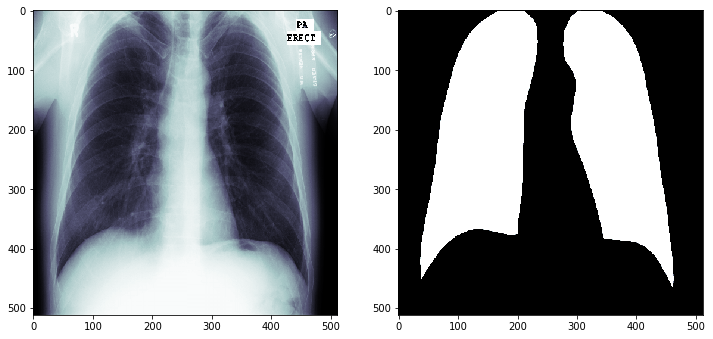

In [5]:
np.random.seed(2018)
t_img, m_img = img_vol[0], seg_vol[0]

fig, (ax_img, ax_mask) = plt.subplots(1,2, figsize = (12, 6))
ax_img.imshow(np.clip(255*t_img, 0, 255).astype(np.uint8) if t_img.shape[2]==3 else t_img[:,:,0],
              interpolation = 'none', cmap = 'bone')
ax_mask.imshow(m_img[:,:,0], cmap = 'bone')

# Simple U-Net Model

In [6]:
from keras.layers import Conv2D, Activation, Input, UpSampling2D, concatenate, BatchNormalization
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
def c2(x_in, nf, strides=1):
    x_out = Conv2D(nf, kernel_size=3, padding='same',
                   kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out
def unet_enc(vol_size, enc_nf, pre_filter = 8):
    src = Input(shape=vol_size + (1,), name = 'EncoderInput')
    # down-sample path.
    x_in = BatchNormalization(name = 'NormalizeInput')(src)
    x_in = c2(x_in, pre_filter, 1)
    x0 = c2(x_in, enc_nf[0], 2)  
    x1 = c2(x0, enc_nf[1], 2)  
    x2 = c2(x1, enc_nf[2], 2)  
    x3 = c2(x2, enc_nf[3], 2) 
    return Model(inputs = [src], 
                outputs = [x_in, x0, x1, x2, x3],
                name = 'UnetEncoder')

Using TensorFlow backend.


In [7]:
from keras.models import Model
from keras import layers
def unet(vol_size, enc_nf, dec_nf, full_size=True, edge_crop=48):
    
    # inputs
    raw_src = Input(shape=vol_size + (1,), name = 'ImageInput')
    src = layers.GaussianNoise(0.25)(raw_src)
    enc_model = unet_enc(vol_size, enc_nf)
    
    x_in, x0, x1, x2, x3 = [s_enc for s_enc in enc_model(src)]

    x = c2(x3, dec_nf[0])
    x = UpSampling2D()(x)
    x = concatenate([x, x2])
    x = c2(x, dec_nf[1])
    x = UpSampling2D()(x)
    x = concatenate([x, x1])
    x = c2(x, dec_nf[2])
    x = UpSampling2D()(x)
    x = concatenate([x, x0])
    x = c2(x, dec_nf[3])
    x = c2(x, dec_nf[4])
    x = UpSampling2D()(x)
    x = concatenate([x, x_in])
    x = c2(x, dec_nf[5])

    
    y_seg = Conv2D(1, kernel_size=3, padding='same', name='lungs', activation='sigmoid')(x)
    y_seg = layers.Cropping2D((edge_crop, edge_crop))(y_seg)
    y_seg = layers.ZeroPadding2D((edge_crop, edge_crop))(y_seg)
    
    model = Model(inputs=[raw_src], outputs=[y_seg])
    return model

In [8]:
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32,32,16,16,2]
net = unet(OUT_DIM, nf_enc, nf_dec)

a= net.predict([np.zeros((1,)+OUT_DIM+(1,))])
print(a.shape)
net.summary()

(1, 512, 512, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageInput (InputLayer)         (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 512, 512, 1)  0           ImageInput[0][0]                 
__________________________________________________________________________________________________
UnetEncoder (Model)             [(None, 512, 512, 8) 24388       gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   9248        UnetEncoder[1][4]                
____________________________________________________________________________________________

In [9]:
from keras.optimizers import Adam
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

reg_param = 1.0
lr = 2e-4
dice_bce_param = 0.0
use_dice = True

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return dice_bce_param*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

net.compile(optimizer=Adam(lr=lr), 
              loss=[dice_p_bce], 
           metrics = [true_positive_rate, 'binary_accuracy'])

# Training Data Generator

Train (110, 512, 512, 1) Test (28, 512, 512, 1) -0.1010681523515081 1.0078740157480315
Seg (110, 512, 512, 1) 1.0 [0. 1.]


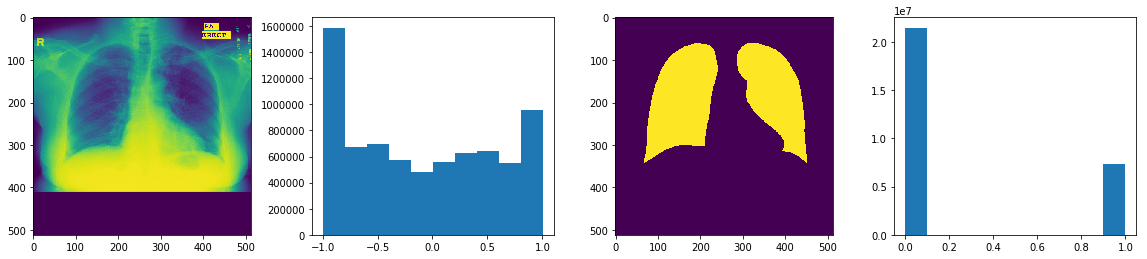

In [10]:
from sklearn.model_selection import train_test_split
train_vol, test_vol, train_seg, test_seg = train_test_split((img_vol-127.0)/127.0, 
                                                            (seg_vol>127).astype(np.float32), 
                                                            test_size = 0.2, 
                                                            random_state = 2018)
print('Train', train_vol.shape, 'Test', test_vol.shape, test_vol.mean(), test_vol.max())
print('Seg', train_seg.shape, train_seg.max(), np.unique(train_seg.ravel()))
fig, (ax1, ax1hist, ax2, ax2hist) = plt.subplots(1, 4, figsize = (20, 4))
ax1.imshow(test_vol[0, :, :, 0])
ax1hist.hist(test_vol.ravel())
ax2.imshow(test_seg[0, :, :, 0]>0.5)
ax2hist.hist(train_seg.ravel());

## Adding Augmentation

In [11]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5, 
                  width_shift_range = 0.05, 
                  height_shift_range = 0.05, 
                  shear_range = 0.01,
                  zoom_range = [0.8, 1.2],  
                  horizontal_flip = True,  
                  vertical_flip = False,
                  fill_mode = 'nearest',
               data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)

def gen_augmented_pairs(in_vol, in_seg, batch_size = 16):
    while True:
        seed = np.random.choice(range(9999))
        g_vol = image_gen.flow(in_vol, batch_size = batch_size, seed = seed)
        g_seg = image_gen.flow(in_seg, batch_size = batch_size, seed = seed)
        for i_vol, i_seg in zip(g_vol, g_seg):
            yield i_vol, i_seg

In [12]:
train_gen = gen_augmented_pairs(train_vol, train_seg, batch_size = 16)
test_gen = gen_augmented_pairs(test_vol, test_seg, batch_size = 16)
train_X, train_Y = next(train_gen)
test_X, test_Y = next(test_gen)
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(16, 512, 512, 1) (16, 512, 512, 1)
(16, 512, 512, 1) (16, 512, 512, 1)


### Training Data

Text(0.5,1,'Seg Image')

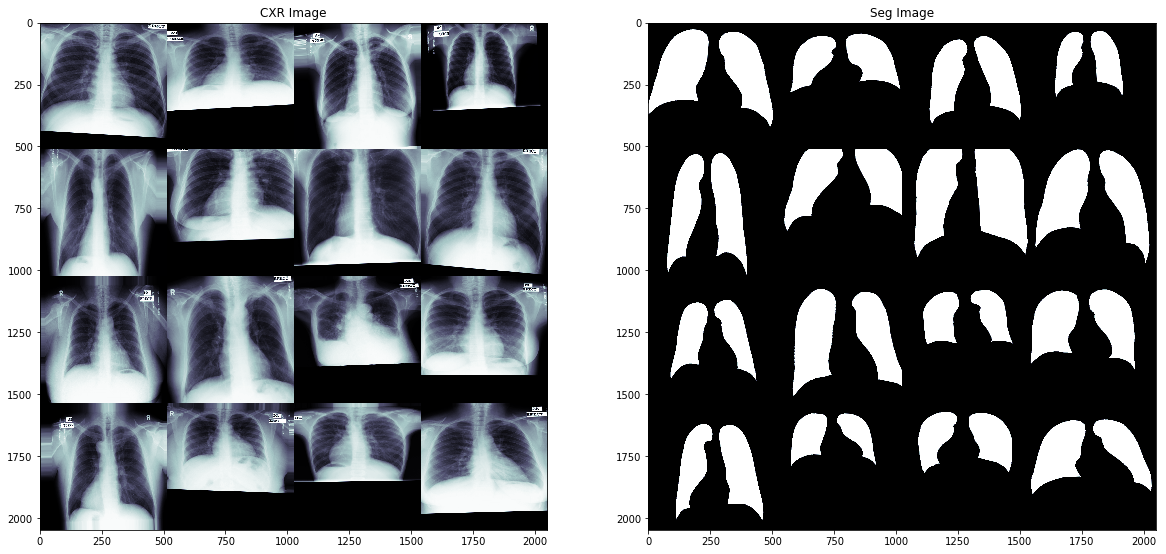

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage2d(train_X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('CXR Image')
ax2.imshow(montage2d(train_Y[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Seg Image')

### Validation Data

Text(0.5,1,'Seg Image')

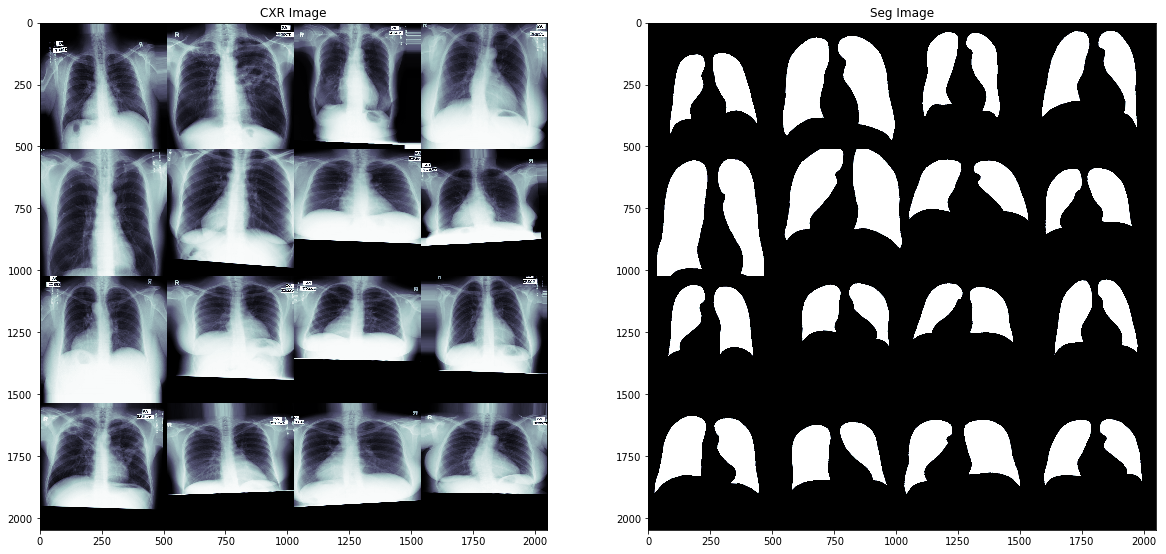

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage2d(test_X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('CXR Image')
ax2.imshow(montage2d(test_Y[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Seg Image')

## Untrained Image masks

In [27]:
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
try:
    from skimage.util.montage import montage2d
except:
    from skimage.util import montage2d
def add_boundary(in_img, in_seg, cmap = 'bone', norm = True, add_labels = True):
    if norm:
        n_img = (1.0*in_img-in_img.min())/(1.1*(in_img.max()-in_img.min()))
    else:
        n_img = in_img
    rgb_img = plt.cm.get_cmap(cmap)(n_img)[:, :, :3]
    if add_labels:
        return label2rgb(image = rgb_img, label = in_seg.astype(int), bg_label = 0)
    else:
        return mark_boundaries(image = rgb_img, label_img = in_seg.astype(int), color = (0, 1, 0), mode = 'thick')
def show_full_st(in_img, in_seg, gt_seg):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
    out_mtg = add_boundary(montage2d(in_img[:, :, :, 0]), 
                           montage2d(gt_seg[:, :, :, 0]>0.5))
    ax1.imshow(out_mtg)
    ax1.set_title('Ground Truth')
    out_mtg = add_boundary(montage2d(in_img[:, :, :, 0]), 
                           montage2d(in_seg[:, :, :, 0]>0.5))
    ax2.imshow(out_mtg)
    ax2.set_title('Prediction')
    out_mtg = montage2d(in_seg[:, :, :, 0]-gt_seg[:, :, :, 0])
    ax3.imshow(out_mtg, cmap='RdBu', vmin=-1, vmax=1)
    ax3.set_title('Difference')
def show_examples(n=1, with_roi = True):
    roi_func = lambda x: x[:, 
                               OUT_DIM[0]//2-32:OUT_DIM[0]//2+32,
                               OUT_DIM[1]//2-64:OUT_DIM[1]//2,
                               :
                              ]
    for (test_X, test_Y), _ in zip(test_gen, range(n)):
        seg_Y = net.predict(test_X)
        show_full_st(test_X, seg_Y, test_Y)
        show_full_st(roi_func(test_X), roi_func(seg_Y), roi_func(test_Y))

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/callbacks.py:919: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.


In [16]:
from IPython.display import clear_output
loss_history = net.fit_generator(train_gen, 
                  steps_per_epoch=len(train_vol)//train_X.shape[0],
                  epochs = 25,
                  validation_data = (test_vol, test_seg),
                  callbacks=callbacks_list
                 )

Epoch 1/25
6/6 [==============================] - 8s 1s/step - loss: -0.4787 - true_positive_rate: 0.8807 - binary_accuracy: 0.6352 - val_loss: -0.5936 - val_true_positive_rate: 0.8244 - val_binary_accuracy: 0.8496

Epoch 00001: val_loss improved from inf to -0.59363, saving model to cxr_reg_weights.best.hdf5
Epoch 2/25
6/6 [==============================] - 5s 831ms/step - loss: -0.6152 - true_positive_rate: 0.8251 - binary_accuracy: 0.8077 - val_loss: -0.6990 - val_true_positive_rate: 0.8068 - val_binary_accuracy: 0.8539

Epoch 00002: val_loss improved from -0.59363 to -0.69898, saving model to cxr_reg_weights.best.hdf5
Epoch 3/25
6/6 [==============================] - 5s 908ms/step - loss: -0.6900 - true_positive_rate: 0.8141 - binary_accuracy: 0.8237 - val_loss: -0.7255 - val_true_positive_rate: 0.8101 - val_binary_accuracy: 0.8540

Epoch 00003: val_loss improved from -0.69898 to -0.72545, saving model to cxr_reg_weights.best.hdf5
Epoch 4/25
6/6 [==============================] - 5

In [17]:
net.load_weights(weight_path)
net.save('full_model.h5')

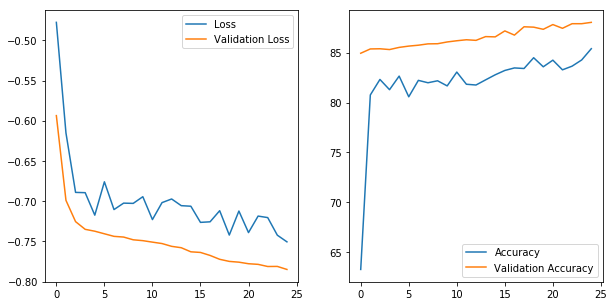

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

### Show results on the training data

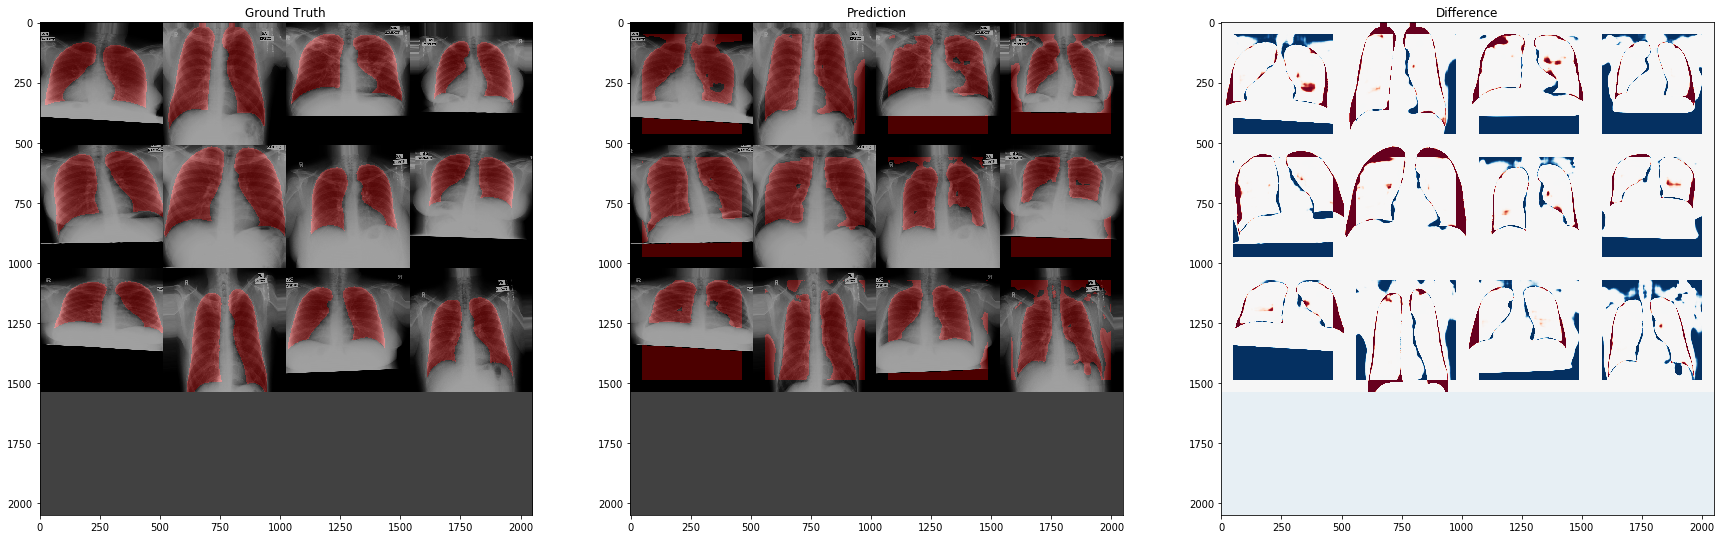

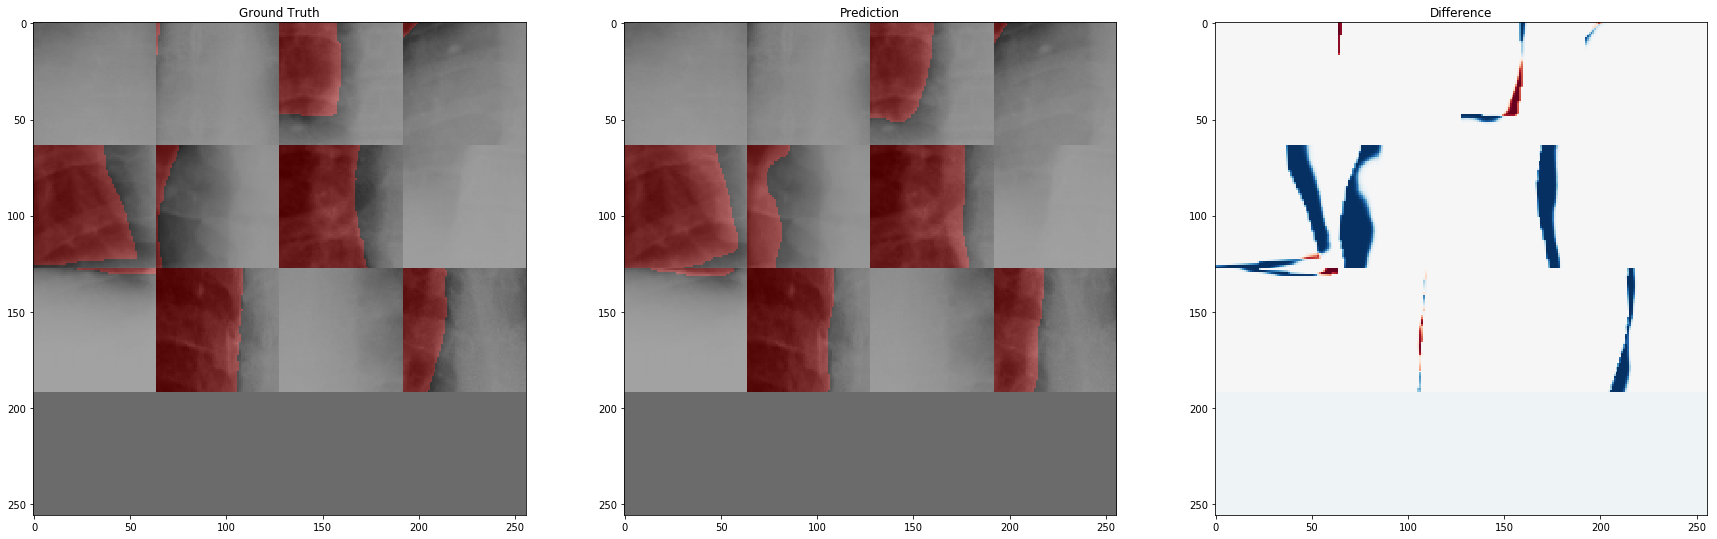

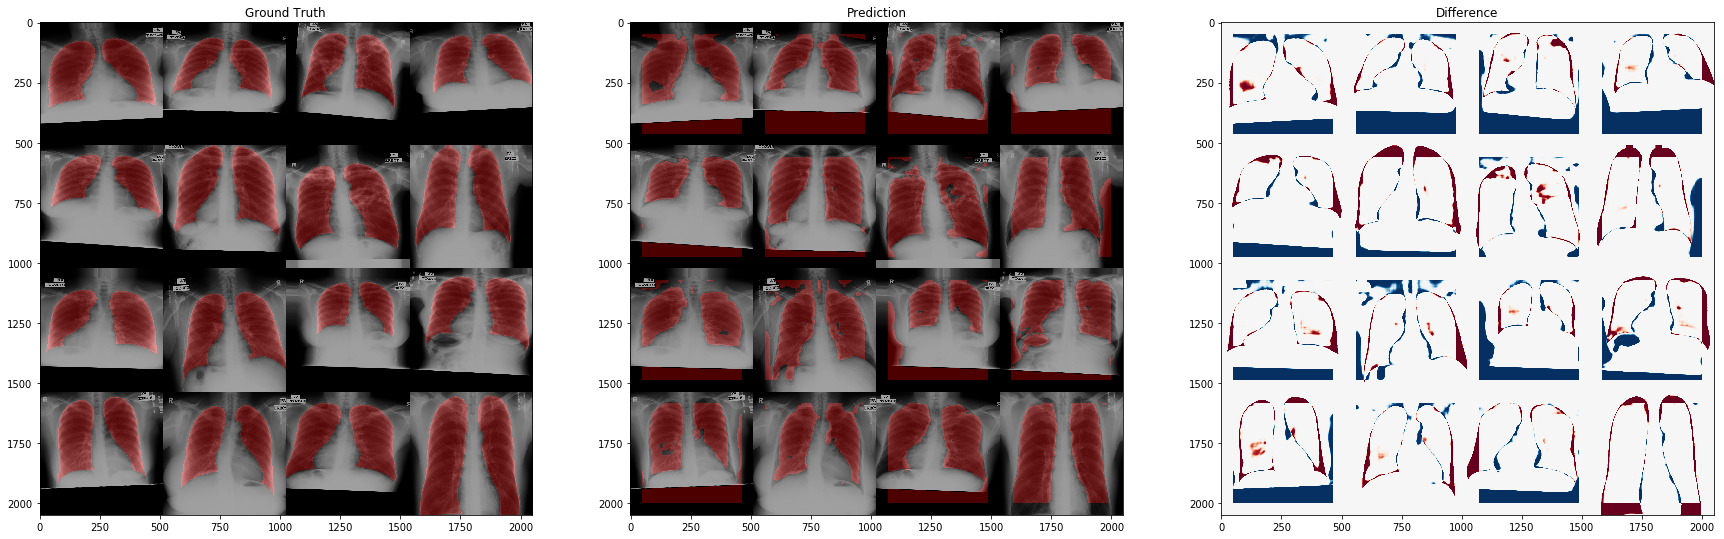

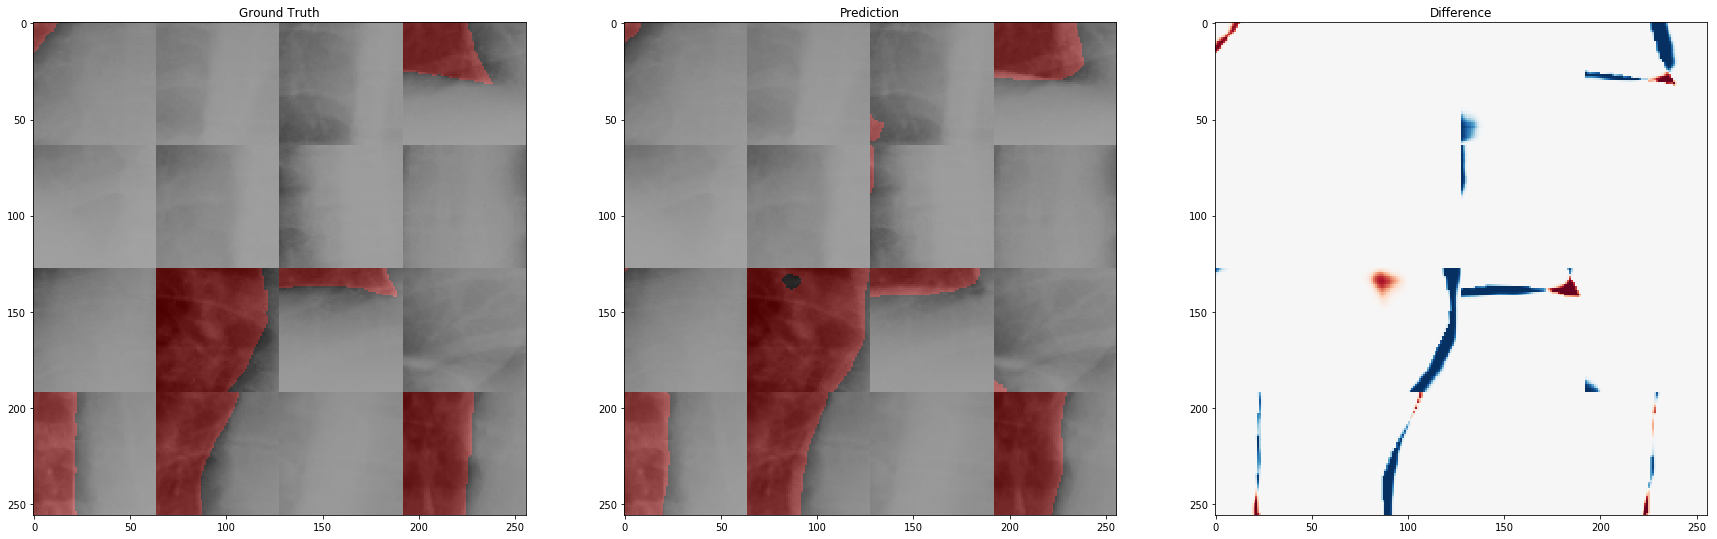

In [21]:
show_examples(2)

# Apply to RSNA Data

In [28]:
import pydicom
from glob import glob
base_rsna_dir = os.path.join('..', 'input', 'rsna-pneumonia-detection-challenge')
test_mean, test_std = test_X.mean(), test_X.std()
def read_dicom_as_float(in_path):
    out_mat = pydicom.read_file(in_path).pixel_array
    norm_mat = (out_mat-1.0*np.mean(out_mat))/np.std(out_mat)
    norm_mat = norm_mat*test_std+test_mean
    return np.expand_dims(norm_mat, -1).astype(np.float32)
all_rsna_df = pd.DataFrame({'path': glob(os.path.join(base_rsna_dir, 
                                                      'stage_*_images', '*.dcm'))})
all_rsna_df.sample(5)

,path
8083,../input/rsna-pneumonia-detection-challenge/st...
22079,../input/rsna-pneumonia-detection-challenge/st...
27161,../input/rsna-pneumonia-detection-challenge/st...
12896,../input/rsna-pneumonia-detection-challenge/st...
21186,../input/rsna-pneumonia-detection-challenge/st...


In [23]:
from keras import layers
in_shape = read_dicom_as_float(all_rsna_df.iloc[0,0]).shape
in_img = layers.Input(in_shape, name='DICOMInput')
scale_factor = (2,2)
ds_dicom = layers.AvgPool2D(scale_factor)(in_img)
unet_out = net(ds_dicom)
us_out = layers.UpSampling2D(scale_factor)(unet_out)
unet_big = Model(inputs=[in_img], outputs=[us_out])
unet_big.save('big_model.h5')
unet_big.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DICOMInput (InputLayer)      (None, 1024, 1024, 1)     0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 512, 512, 1)       0         
_________________________________________________________________
model_1 (Model)              (None, 512, 512, 1)       99589     
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 1024, 1024, 1)     0         
Total params: 99,589
Trainable params: 99,587
Non-trainable params: 2
_________________________________________________________________


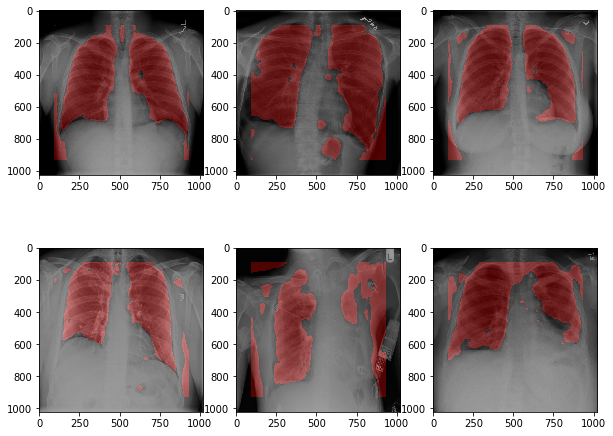

In [24]:
fig, m_axs = plt.subplots(2, 3, figsize = (10, 8))
for c_ax, (_, c_row) in zip(m_axs.flatten(), 
                            all_rsna_df.sample(6).iterrows()):
    c_img = read_dicom_as_float(c_row['path'])
    c_seg = unet_big.predict(np.expand_dims(c_img, 0))[0]
    c_ax.imshow(add_boundary(c_img[:, :, 0], c_seg[:, :, 0]>0.5))

## Prediction and exporting masks

In [29]:
import zipfile as zf
from io import BytesIO
from PIL import Image
batch_size = 12
with zf.ZipFile('masks.zip', 'w') as f:
    for i, c_rows in tqdm(all_rsna_df.groupby(lambda x: x//batch_size)):
        cur_x = np.stack(c_rows['path'].map(read_dicom_as_float), 0)
        cur_pred = unet_big.predict(cur_x)>0.5
        for out_img, (_, c_row) in zip(cur_pred[:, :, :, 0], c_rows.iterrows()):
            arc_name = os.path.relpath(c_row['path'], base_rsna_dir)
            arc_name, _ = os.path.splitext(arc_name)
            out_pil_obj = Image.fromarray((255*out_img).astype(np.uint8))
            out_obj = BytesIO()
            out_pil_obj.save(out_obj, format='png')
            out_obj.seek(0)
            f.writestr('{}.png'.format(arc_name), out_obj.read(), zf.ZIP_STORED)

100%|██████████| 2474/2474 [27:19<00:00,  1.51it/s]


In [30]:
!ls -lh *.zip

-rw-r--r-- 1 root root 167M May  3 06:10 masks.zip
